In [ ]:

import tweepy
import json
import re
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import demoji
demoji.download_codes()

from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import collections

... OK (Got response in 0.11 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# twitter api keys
consumer_key = 'CfqZfNRTvcHdDRCo23PZt3ETa'
consumer_key_secret = '9NVfiSz9tcp2GvLDchPxfh2sNLHKpmUVwfvuxeCPwdjKM14upU'
access_token = '1223923047490445312-gNkYAcwaS1HDVmQfi7KF0YJQBpokZW'
access_token_secret = 'ZZ5iad8aXQCrvI9NnAzqZxYBTdKHb81WubYeLeAiQ3T8i'

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)

auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
#pip install demoji

In [ ]:
# tweet extraction function
def extract_tweet(name, maxi):
  max_tweets = maxi
  screen_name = name
  
  tweets = api.user_timeline(screen_name = screen_name,
                           tweet_mode = 'extended',
                           count = max_tweets)
  list_of_dicts = []
  photo_list = []

  for json_tweet in tweets:
    list_of_dicts.append(json_tweet._json)
    for media in json_tweet.entities.get("media", [{}]):
      if media.get("type", None) == "photo":
        photo_list.append("Yes")
      else:
        photo_list.append("No")

  with open('%s_tweets.json' % name, mode = 'w') as file:
    file.write(json.dumps(list_of_dicts, indent = 4))
  
  with open("%s_photo.txt" % name, mode = 'w') as file:
    file.write(json.dumps(photo_list))

In [ ]:
# use tweet extraction function
user = ["KingJames", "Alison_McGovern"]
maxi = 200

for name in user:
  extract_tweet(name, maxi)

In [ ]:
dict_u1 = []
dict_u2 = []
cnt = 0

for name in user:
  if cnt == 0:
    with open('%s_tweets.json' % name, mode = 'r', encoding = 'utf-8') as file:
      dict_u1 = (json.load(file))
    cnt = cnt + 1
  else:
     with open('%s_tweets.json' % name, mode = 'r', encoding = 'utf-8') as file:
       dict_u2 = (json.load(file))

In [ ]:
dict_arr = [dict_u1, dict_u2]
tweet_list = []

for dct in dict_arr:
  for tweet in dct:
    list_per_tweet = []
    text = tweet["full_text"]
    created_at = tweet["created_at"]
    source = tweet["source"]
    user = tweet["user"]["screen_name"]
    list_per_tweet.extend((user, text, created_at, source))
    tweet_list.append(list_per_tweet)

In [ ]:
tweet_df = pd.DataFrame(tweet_list, columns = ["screen_name", "text", "created_at", "source"])

source_list = tweet_df["source"].tolist()
os_list = []
for tweet in source_list:
  boo = "iPhone" in tweet
  if boo == True:
    os_list.append("iPhone")
  else:
    os_list.append("Android")

tweet_df["source"] = os_list
tweet_df["created_at"] = pd.to_datetime(tweet_df["created_at"])

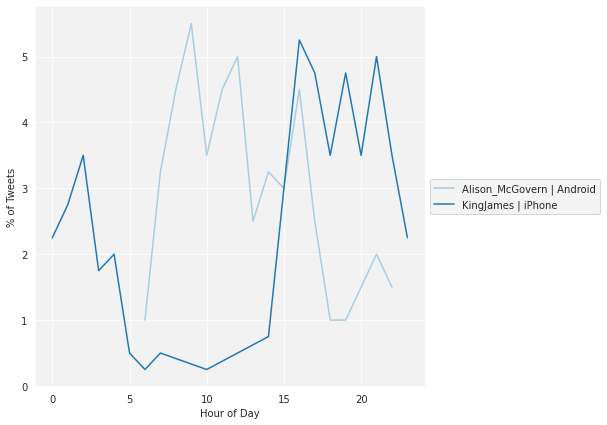

In [ ]:
hour_list = []

for h in tweet_df["created_at"]:
  hour_list.append(h.hour)

tweet_df["user_source"] = tweet_df["screen_name"].map(str) + " | " + tweet_df["source"].map(str)
tweet_df["hour"] = hour_list
fig1_data = tweet_df.groupby("user_source")["hour"].value_counts().sort_index()
fig1_data = fig1_data.reset_index(level = 'user_source')
fig1_data.index.name = "time_hours"
fig1_data.columns = ["user_source", "count_hours"]

hour_list = []
for p in fig1_data["count_hours"]:
  hour_list.append((p/400)*100)
fig1_data["count_hours"] = hour_list

plt.figure(figsize = (7, 7))
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
ax = sns.lineplot(data = fig1_data, x = "time_hours", y = "count_hours", hue = "user_source", palette = "Paired")
ax.set(xlabel = "Hour of Day", ylabel = "% of Tweets")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [ ]:
user = ["KingJames", "Alison_McGovern"]
img_u1 = []
img_u2 = []
cnt = 0

for name in user:
  if cnt == 0:
    with open('%s_photo.txt' % name, mode = 'r', encoding = 'utf-8') as file:
      img_u1 = (json.load(file))
    cnt = cnt + 1
  else:
     with open('%s_photo.txt' % name, mode = 'r', encoding = 'utf-8') as file:
       img_u2 = (json.load(file))

img_df = pd.DataFrame(img_u1, columns=["with_photo"])
img_df = img_df.append(pd.DataFrame(img_u2, columns=["with_photo"]), ignore_index = True)
tweet_df = pd.concat([tweet_df, img_df], axis = 1)

In [ ]:
text_list = tweet_df["text"].tolist()
url_list = []

for tweet in text_list:
  url = re.findall(r'https?:\/\/.*[\r\n]*', tweet)
  if not url:
    url_list.append("No")
  else:
    url_list.append("Yes")

tweet_df["with_url"] = url_list

<Figure size 360x360 with 0 Axes>

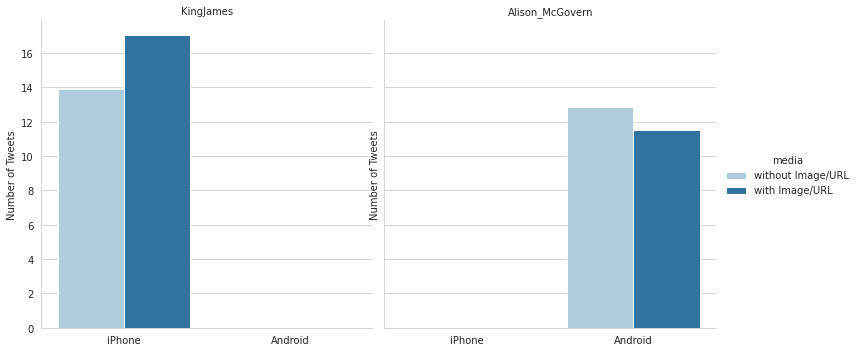

In [ ]:
img_url = tweet_df.with_photo.str.contains("No") & tweet_df.with_photo.str.contains("No").to_list()
tweet_df["media"] = img_url
tweet_df["media"] = tweet_df["media"].replace(True,"without Image/URL")
tweet_df["media"] = tweet_df["media"].replace(False,"with Image/URL")

plt.figure(figsize = (5, 5))
sns.set_style("whitegrid")
ax = sns.catplot(x = "source", y = "hour", hue = "media", col = "screen_name", data = tweet_df, palette = "Paired", kind = "bar", ci = None)
ax.set(xlabel = "", ylabel = "Number of Tweets")
ax.set_titles(col_template = "{col_name}")

[Text(0, 0.5, 'Number of Tweets'),
 Text(0.5, 0, 'Number of Hashtags per Tweet')]

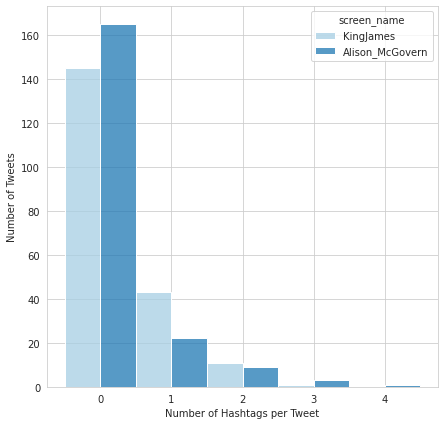

In [ ]:
hash_list = []

for tweet in text_list:
  hash = re.findall(r'#(\w+)', tweet)
  hash_list.append(len(hash))

tweet_df["hashtag"] = hash_list

plt.figure(figsize = (7, 7))
ax = sns.histplot(tweet_df, x = "hashtag", hue = "screen_name", multiple="dodge", discrete = True, palette = "Paired")
ax.set(xlabel = "Number of Hashtags per Tweet", ylabel = "Number of Tweets")

In [ ]:
user = ["KingJames", "Alison_McGovern"]
cnt = 0
raw_text_list = []

for tweet in text_list:
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags = re.MULTILINE)
  tweet = demoji.replace(tweet, "")
  raw_text_list.append(re.sub(r"[^a-zA-Z0-9#@\']+", ' ', tweet))

tweet_df["raw_text"] = raw_text_list

def token_clean(list):
  token_list = [regexp_tokenize(tweet, "[\w^a-zA-Z0-9#@\']+") for tweet in list]
  token_list = [word.lower() for sublist in token_list for word in sublist]
  cachedStopWords = set(stopwords.words("english"))
  remove_stop_list =  [word for word in token_list if not word in cachedStopWords]
  retweet = ["rt", "rts", "retweet"]
  clean_list =  [word for word in remove_stop_list if not word in retweet]
  return clean_list

for name in user:
  if cnt == 0:
    raw_list_u1 = tweet_df["raw_text"].loc[tweet_df["screen_name"] == name].to_list()
    clean_list_u1 = token_clean(raw_list_u1)
    word_cnt_u1 = collections.Counter(clean_list_u1)
    cnt = cnt + 1
  else:
    raw_list_u2 = tweet_df["raw_text"].loc[tweet_df["screen_name"] == name].to_list()
    clean_list_u2 = token_clean(raw_list_u2)
    word_cnt_u2 = collections.Counter(clean_list_u2)

In [ ]:
wcu1_df = pd.DataFrame.from_dict(word_cnt_u1, orient = 'index').sort_values(0, ascending = False).reset_index()
wcu1_df.columns = ["words", "counts"]
wcu1_df["screen_name"] = "KingJames"

wcu2_df = pd.DataFrame.from_dict(word_cnt_u2, orient = 'index').sort_values(0, ascending = False).reset_index()
wcu2_df.columns = ["words", "counts"]
wcu2_df["screen_name"] = "Alison_McGovern"

top_df = pd.concat([wcu1_df, wcu2_df]).reset_index()
top_df = top_df.drop(columns = ["index"])

In [ ]:
total_cnt = []
cnt = 0
while cnt != 2:
  total_cnt.append(top_df.groupby("screen_name")["counts"].sum()[cnt])
  cnt = cnt + 1

log_odds = []
for word in wcu1_df["words"]:
  if word not in wcu2_df.values:
    u2_count = 0
  else:
    u2_count = wcu2_df[wcu2_df.words == word].counts.item()
  u1_count = wcu1_df[wcu1_df.words == word].counts.item()
  log_odds.append(np.log2(((u1_count + 1)/(total_cnt[0] + 1))/((u2_count + 1)/(total_cnt[1] + 1))))
for word in wcu2_df["words"]:
  if word not in wcu1_df.values:
    u1_count = 0
  else:
    u1_count = wcu1_df[wcu1_df.words == word].counts.item()
  u2_count = wcu2_df[wcu2_df.words == word].counts.item()
  log_odds.append(np.log2(((u2_count + 1)/(total_cnt[1] + 1))/((u1_count + 1)/(total_cnt[0] + 1))))
top_df["log_odds"] = log_odds

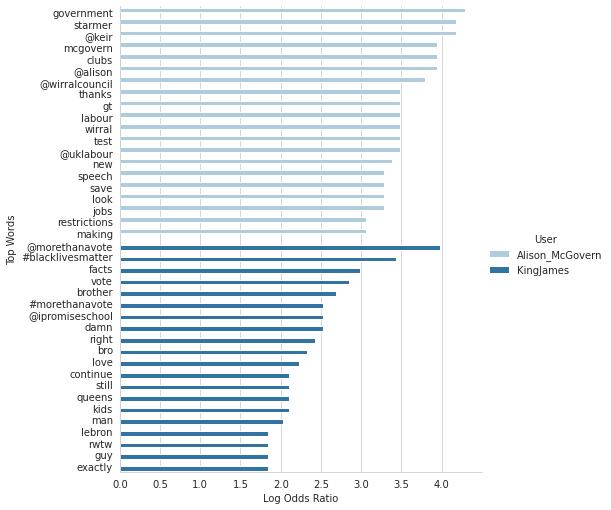

In [ ]:
top_odds = top_df.groupby("screen_name").apply(lambda odds: odds.sort_values("log_odds", ascending = False))
top_odds = top_odds.reset_index(drop=True)
top_odds = top_odds.groupby("screen_name").head(20)
top_odds = top_odds.reset_index(drop = True)

sns.set_style("whitegrid")
ax = sns.catplot(x = "log_odds", y = "words", hue = "screen_name", data = top_odds, kind = "bar", orient = "h", palette = "Paired", height = 7)
ax.set(xlabel="Log Odds Ratio", ylabel = "Top Words")
ax._legend.set_title("User")

[Text(0, 0.5, 'Tweet Count'), Text(0.5, 0, 'User')]

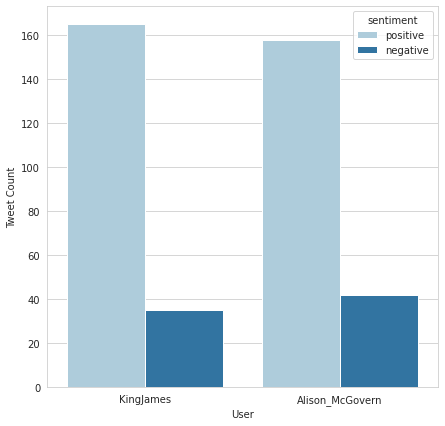

In [ ]:
##########################################################################################
## source: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664 ##
##########################################################################################

sid = SentimentIntensityAnalyzer()

tweet_df["scores"] = tweet_df["text"].apply(lambda tweet: sid.polarity_scores(tweet))
tweet_df["compound"] = tweet_df["scores"].apply(lambda score: score["compound"])
tweet_df["sentiment"] = tweet_df["compound"].apply(lambda comp: "positive" if comp >= 0 else "negative")

plt.figure(figsize = (7, 7))
ax = sns.countplot(x = "screen_name", hue = "sentiment", data = tweet_df, palette="Paired")
ax.set(xlabel="User", ylabel = "Tweet Count")

In [ ]:
comp_ave_df = tweet_df.groupby("screen_name")["compound"].mean()
comp_ave_df = comp_ave_df.to_frame()
comp_ave_df

,compound
screen_name,
Alison_McGovern,0.212372
KingJames,0.187490


In [ ]:
tweet_df[tweet_df["screen_name"]=="KingJames"].to_csv('KingJames_tweet.csv',header=True, index=False)
tweet_df[tweet_df["screen_name"]=="Alison_McGovern"].to_csv('Alison_McGovern_tweet.csv',header=True, index=False)